In [2]:
import timeit
import numpy as np

In [5]:
result_sets = np.logspace(0, 5, 6)

In [6]:
from drillpy import PyQuery
import timeit

def run(connString):
    def doRun():
        R1 = PyQuery()
        df = R1.get_cols(connString)
        return df
    return doRun

native_times = {}
for results in result_sets:
    connString = {'query' : "select * from dfs.flights.flights_by_yr limit {}".format(results), 
                  'type': 'sql', 
                  'connectStr' : 'local=172.17.0.2:31010',
                  'api' : 'async',
                  'logLevel' : 'error'}
    result = run(connString)
    native_times[results] = timeit.Timer(run(connString)).repeat(repeat=3, number=1)

In [7]:
native_times

{1.0: [0.9399796170000627, 0.8564439839974511, 0.8398932630007039],
 10.0: [0.6567929930024548, 0.8168459950029501, 0.7582980629995291],
 100.0: [0.7942459280020557, 1.1440514709975105, 0.7870020159971318],
 1000.0: [1.1471055620022526, 0.8680741989992384, 1.7381350799987558],
 10000.0: [0.8172753159997228, 0.7614589349977905, 0.9958444450021489],
 100000.0: [1.2255906339996727, 1.2843218609996256, 1.1521839920023922]}

In [8]:
from turbodbc import connect, make_options, Megabytes
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
options = make_options(read_buffer_size=Megabytes(20),
                                           autocommit=True)

conn = connect(dsn='drill', turbodbc_options=options)

turbo_times = {}
for results in result_sets:
    sql = 'select * from dfs.flights.flights_by_yr limit {}'.format(results)
    fun = lambda: conn.cursor().execute(sql).fetchallarrow().to_pandas()
    turbo_times[results] = timeit.Timer(fun).repeat(repeat=3, number=1)

In [9]:
turbo_times

{1.0: [1.427049406000151, 1.454430735000642, 1.5133645350033476],
 10.0: [1.916845949999697, 2.1651370339968707, 2.607393256999785],
 100.0: [5.306731958000455, 3.446397812000214, 1.7264559200011718],
 1000.0: [1.5769829050004773, 1.5140927219981677, 1.419495639998786],
 10000.0: [1.4182390429996303, 1.691020483001921, 1.6073000569995202],
 100000.0: [3.178179177997663, 2.725107329999446, 2.779163975999836]}

In [10]:
turbo_times_dict = {}
for results in result_sets:
    sql = 'select * from dfs.flights.flights_by_yr limit {}'.format(results)
    fun = lambda: conn.cursor().execute(sql).fetchallarrow(strings_as_dictionary=True).to_pandas()
    turbo_times_dict[results] = timeit.Timer(fun).repeat(repeat=3, number=1)

In [11]:
turbo_times_dict

{1.0: [1.9465457900005276, 4.112134221002634, 3.1184984110004734],
 10.0: [1.7224633779987926, 1.6441453189981985, 1.5031782080004632],
 100.0: [1.442834382000001, 1.5546816049973131, 1.7654160210004193],
 1000.0: [2.6063263489995734, 2.2386571490023925, 1.743686780999269],
 10000.0: [1.7723881370002346, 1.8055625979977776, 1.880482349999511],
 100000.0: [2.2753090279984463, 2.5793463709997013, 2.3818587650021072]}

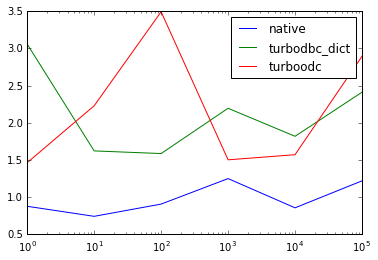

In [32]:
%matplotlib inline
ttd = pd.DataFrame(turbo_times_dict).T.mean(axis=1)
tt = pd.DataFrame(turbo_times).T.mean(axis=1)
nt = pd.DataFrame(native_times).T.mean(axis=1)
pd.DataFrame({"turbodbc_dict" : ttd, "turboodc" : tt, "native" : nt}).plot(logx=True)

In [38]:
df_n = run(connString)()

In [39]:
df_t = fun()

In [46]:
pd.DataFrame([df_t.dtypes.sort_index(), df_n.dtypes]).T

,0,1
ActualElapsedTime,float64,float64
AirTime,float64,float64
ArrDelay,float64,float64
ArrTime,float64,int32
CRSArrTime,int64,int32
CRSDepTime,int64,int32
CRSElapsedTime,float64,float64
CancellationCode,category,object
Cancelled,bool,bool
CarrierDelay,float64,int32


In [47]:
df_t.memory_usage().sum()

19233312

In [48]:
df_n.memory_usage().sum()

15800080